In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

### 1. Loading MNIST data from keras dataset and visualizing
- After pip installing tensorflow, if not installed before, restart the environment.
- The data has been pre-split by default.

In [2]:
# Loading MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Checking shape of data
print(X_train.shape) ## 60,000 images, 28 x 28 size
print(y_train.shape) ## 60,000 labels for each image

(60000, 28, 28)
(60000,)


Visualizing sample images from MNIST dataset:


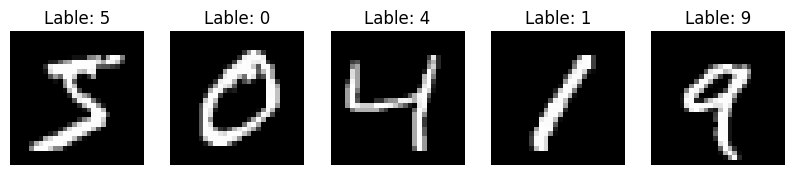

In [3]:
# Function to visualize a few training images
def visualize_samples(X, y, n = 5):
    plt.figure(figsize=(10,2))
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(X[i], cmap = 'gray')
        plt.title(f"Lable: {y[i]}")
        plt.axis('off')
    plt.show()

print("Visualizing sample images from MNIST dataset:")
visualize_samples(X_train, y_train)


### 2. Preprocessing data, normalizing pixel values
- The datasets are already split and given in an array.
- For MNIST, each pixel value is an integer [0, 255], on a scale from black to white respectively. We are normalizing the data between 0 and 1
- This improves convergence/ convergence speed. Gradients become more uniform, allowing for gradient descent or SGD to be faster.
- Since the shape is 28x28, we have to flatten the datasets into a one-dimensional vector 

In [4]:
# Normalizing data between 0 and 1 
X_train = X_train / 255.0
X_test = X_test / 255.0

# Flattening dataset to be a one-dimensional vector
X_train_flat = X_train.reshape(X_train.shape[0], -1).T  ## Shape becomes (784, 60000)
X_test_flat = X_test.reshape(X_test.shape[0], -1).T      ## Shape becomes (784, 60000)

### 3. Initializing parameters and functions
- This prepares the activation functions used in this neural network
- We initialize weights and biases with random values [-0.5, 0.5], preventing network from starting with bias towards any direction.
- Biases can be set at 0 for simplicity. But this could lead to dead neurons that never activate with ReLU.

In [5]:
# ReLU activation function, returning Z if > 0, returning 0 if =< 0
def ReLU(Z):
    return np.maximum(Z,0)

# ReLU derivative. The ReLU derivative is 1 for Z > 0 and 0 if Z =< 0
def ReLU_deriv(Z):
    return Z > 0 ## Forces a boolean that takes Z > 0 as true (1), Z =< 0 as false (0)

# Softmax activation function
def softmax(Z):
    return np.exp(Z) / sum(np.exp(Z))

# Function to initialize Hidden Layer 1 (H1) and Hidden Layer 2 (H2)
def init_params():
    # Initializing weights with random values [-0.5, 0.5]
    W1 = np.random.rand(10, 784) - 0.5 ## H1 consists of 10 hidden neurons, 784 input neurons
    b1 = np.random.rand(10, 1) - 0.5  

    W2 = np.random.rand(10, 10) - 0.5 ## H2 consists of 10 hidden neurons, 10 input neurons from H1
    b2 = np.random.rand(10, 1) - 0.5 
    return W1, b1, W2, b2

# Forward propogation - Output of H1 (A1) uses ReLU and output of H2 (A2) uses Softmax
def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1) ## H1 output after activation function
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2) ## H2 output after activation function
    return Z1, A1, Z2, A2

# One-hot encoding output, Y, a matrix where column represents individual Y predictions [0, 1, 0, .....]
def one_hot(Y):
    # Creates a matrix of zeros with dimensions (no. of labels, no. of classes)
    one_hot_Y = np.zeros((Y.size, Y.max() + 1)) ## Y.size should be 60,000 labels, number of classes is 10, from 0 to 9 (Y.max=9 therefore +1)
    # Converts 0 matrix into one-hot encoded matrix
    one_hot_Y[np.arange(Y.size), Y] = 1 ## This replaces 0 with 1 depending on Y value. If Y = 1, the specific row vector is [0,1,0,0.....]
    # Takes transpose of one_hot_Y above
    one_hot_Y = one_hot_Y.T ## the row vector becomes a column vector
    return one_hot_Y

# Back propogation
def back_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    # The loss function is not neccessary to indicate because cross-entropy loss is combined from using softmax function!
    m = Y.size ## m is size of dataset, 60,000
    one_hot_Y = one_hot(Y) 
    dZ2 = A2 - one_hot_Y ## Difference between predicted output, A2 and Y prediction (the residual)
    dW2 = 1 / m * dZ2.dot(A1.T) ## Matrix multiplcation of dZ2 and A1, giving us the gradient of loss wrt w2, over the size of 60,000
    db2 = 1 / m * np.sum(dZ2) ## Gradient of loss function wrt to bias term b2
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)
    return dW1, db1, dW2, db2

# Updating parameters after back prop
def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1
    W2 = W2 - alpha * dW2
    b2 = b2 - alpha * db2
    return W1, b1, W2, b2

### 4.0 Defining our gradient descent
- The following cell calls all the parameters and predictions calculated above to perform batch gradient descent.

In [6]:
# Returns the highest probability in the array
def get_predictions(A2):
    return np.argmax(A2, 0)

# Simple accuracy function
def get_accuracy(predictions, Y):
    print(predictions, Y)
    return np.sum(predictions == Y) / Y.size

# Using general gradient descent
def gradient_descent(X ,Y, iterations, alpha):
    W1, b1, W2, b2 = init_params()
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = back_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        
        if (i % 10 == 0): ## Every 10 iterations
            print("Iteration: ", i)
            print("Accuracy: ", get_accuracy(get_predictions(A2), Y))
    return W1, b1, W2, b2

W1, b1, W2, b2 = gradient_descent(X_train_flat, y_train, 500, 0.1)

Iteration:  0
[3 9 5 ... 3 0 1] [5 0 4 ... 5 6 8]
Accuracy:  0.12926666666666667
Iteration:  10
[4 6 5 ... 5 0 1] [5 0 4 ... 5 6 8]
Accuracy:  0.2183
Iteration:  20
[4 6 4 ... 5 6 1] [5 0 4 ... 5 6 8]
Accuracy:  0.2804
Iteration:  30
[4 6 4 ... 5 6 1] [5 0 4 ... 5 6 8]
Accuracy:  0.3294666666666667
Iteration:  40
[4 6 4 ... 9 6 1] [5 0 4 ... 5 6 8]
Accuracy:  0.36761666666666665
Iteration:  50
[4 0 4 ... 9 6 1] [5 0 4 ... 5 6 8]
Accuracy:  0.4038333333333333
Iteration:  60
[8 0 4 ... 9 6 1] [5 0 4 ... 5 6 8]
Accuracy:  0.44525
Iteration:  70
[8 0 4 ... 9 6 1] [5 0 4 ... 5 6 8]
Accuracy:  0.49211666666666665
Iteration:  80
[5 0 4 ... 9 6 1] [5 0 4 ... 5 6 8]
Accuracy:  0.5343833333333333
Iteration:  90
[5 0 4 ... 9 6 1] [5 0 4 ... 5 6 8]
Accuracy:  0.5675166666666667
Iteration:  100
[5 0 4 ... 9 6 1] [5 0 4 ... 5 6 8]
Accuracy:  0.5956
Iteration:  110
[5 0 4 ... 9 6 8] [5 0 4 ... 5 6 8]
Accuracy:  0.6191
Iteration:  120
[5 0 4 ... 9 6 8] [5 0 4 ... 5 6 8]
Accuracy:  0.6400833333333333
I

### 5.0 Visualizing Accuracy over epochs and predictions on a random set of 10 numbers.

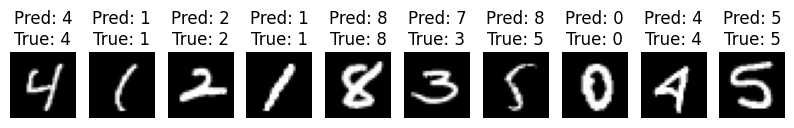

In [7]:
def visualize_random_predictions(X_test, y_test, model, num_samples=10):
    # Randomly select samples
    random_indices = np.random.choice(X_test.shape[1], num_samples, replace=False)

    # Get the selected images and labels
    X_random = X_test[:, random_indices]
    y_random = y_test[random_indices]

    # Forward pass 
    Z1, A1, Z2, A2 = forward_prop(model['W1'], model['b1'], model['W2'], model['b2'], X_random)
    predictions = get_predictions(A2)

    # Plotting images + their predicted and true values
    plt.figure(figsize=(10, 2))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(X_random[:, i].reshape(28, 28), cmap='gray')
        pred_label = predictions[i]
        true_label = y_random[i]
        plt.title(f"Pred: {pred_label}\nTrue: {true_label}")
        plt.axis('off')
    plt.show()

visualize_random_predictions(X_test_flat, y_test, {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2})

### 6.0 Attempt at Stochastic Gradient Descent (SGD)
- This is still experimental, I will finish this when I find the motivation to work on this dataset again :)

In [8]:
def one_hot_sgd(Y):
    one_hot_Y = np.zeros((10,1)) ## Taking 10 for 10 classes
    one_hot_Y[Y] =1
    return one_hot_Y

def back_prop_sgd(Z1, A1, Z2, A2, W1, W2, X, Y):
    m = 1  # m is size 1 as we are doing SGD, each backprop is size 1
    one_hot_Y = one_hot_sgd(Y)  # One-hot encode the label
    dZ2 = A2 - one_hot_Y  # Difference between predicted output, A2, and Y prediction (the residual)
    dW2 = 1 / m * dZ2.dot(A1.T)  # Gradient of loss wrt W2
    db2 = 1 / m * np.sum(dZ2)  # Gradient of loss wrt b2
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)  # Backprop to first layer
    dW1 = 1 / m * dZ1.dot(X.T)  # Gradient of loss wrt W1
    db1 = 1 / m * np.sum(dZ1)  # Gradient of loss wrt b1
    return dW1, db1, dW2, db2

def sgd(X, Y, iterations, alpha):
    W1, b1, W2, b2 = init_params()  
    for i in range(iterations):  
        for j in range(X.shape[1]):  # Iterate over each sample (SGD)
            X_single = X[:, j:j+1]  # Select a single column from X (one sample)
            Y_single = Y[j] # Select single Y
            
            # Forward propagation
            Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X_single)
            
            # Backpropagation
            dW1, db1, dW2, db2 = back_prop_sgd(Z1, A1, Z2, A2, W1, W2, X_single, Y_single)
            
            # Update parameters
            W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        
        # Print accuracy every 10 iterations
        if (i % 10 == 0):
            print("Iteration: ", i)
            print("Accuracy: ", get_accuracy(get_predictions(A2), Y))
    
    # Return parameters after all iterations are complete
    return W1, b1, W2, b2

W1, b1, W2, b2 = sgd(X_train_flat, y_train, 500, 0.1)

Iteration:  0
[3] [5 0 4 ... 5 6 8]
Accuracy:  0.10218333333333333


C:\Users\script.pc #93\AppData\Local\Temp\ipykernel_3788\170867651.py:11: RuntimeWarning: overflow encountered in exp
  return np.exp(Z) / sum(np.exp(Z))
C:\Users\script.pc #93\AppData\Local\Temp\ipykernel_3788\170867651.py:11: RuntimeWarning: invalid value encountered in divide
  return np.exp(Z) / sum(np.exp(Z))


Iteration:  10
[0] [5 0 4 ... 5 6 8]
Accuracy:  0.09871666666666666


KeyboardInterrupt: 